<font size = "5"> **[Image Tools](2_Image_Tools.ipynb)** </font>

<hr style="height:2px;border-top:4px solid #FF8200" />


# Adaptive Fourier Filtering


[<img src=https://www.coeuscreativegroup.com/wp-content/uploads/2020/04/download-button.png, width=125>](https://raw.githubusercontent.com/pycroscopy/pyTEMlib/main/notebooks/Imaging/Adaptive_Fourier_Filter.ipynb) 

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/pycroscopy/pyTEMlib/blob/main/notebooks/Imaging/Adaptive_Fourier_Filter.ipynb)
    
    

part of 

<font size = "5"> **[pyTEMlib](https://pycroscopy.github.io/pyTEMlib/about.html)**</font>

a [pycroscopy](https://pycroscopy.github.io/pycroscopy/about.html) ecosystem package


Notebook by Gerd Duscher, 2023

Microscopy Facilities<br>
Institute of Advanced Materials & Manufacturing<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes


## Content
An introduction into Fourier Filtering of images.


## Install pyTEMlib

If you have not done so in the [Introduction Notebook](../0_pyTEMlib.ipynb), please test and install [pyTEMlib](https://github.com/gduscher/pyTEMlib) and other important packages with the code cell below.


In [1]:
import sys
import importlib.metadata
def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = importlib.metadata.version(package_name)
    except importlib.metadata.PackageNotFoundError:
        version = '-1'
    return version

if test_package('pyTEMlib') < '0.2024.1.0':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade pyTEMlib -q
if 'google.colab' in sys.modules:
    !{sys.executable} -m pip install numpy==1.24.4
print('done')


installing pyTEMlib
done


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mkl-fft 1.3.8 requires mkl, which is not installed.


## Loading of necessary libraries

Please note, that we only need to load the pyTEMlib library, which is based on sidpy Datasets. 



In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pylab as plt 
import sys

if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()
    from google.colab import drive

import sys
sys.path.insert(0, '../..')
%load_ext autoreload
%autoreload 2

import pyTEMlib
import pyTEMlib.file_tools      # File input/ output library
import pyTEMlib.image_tools 

if 'google.colab' in sys.modules:
    drive.mount("/content/drive")
    
print('pyTEMlib version: ', pyTEMlib.__version__)
note_book_version = '2023.01.20'
note_book_name='pyTEMib/notebooks/Imaging/Adaptive_Fourier_Filter'

You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.
Symmetry functions of spglib enabled
SimpleITK not installed; Registration Functions for Image Stacks not available
install with: conda install -c simpleitk simpleitk 
pyTEMlib version:  0.2024.02.0


## Open File

The data are held in the memory in the **sidpy** format with rather extensive capabilities.

All results can be stored in that **NSID** format file. 

First we select the file and the dataset (the dropdown menu at the bottom), in case there are several.

In [2]:
fileWidget = pyTEMlib.file_tools.FileWidget()


Now, we open and plot the selected dataset. Select another one and rerun only cell below (Home button gets you back to original).
>
> Please note that you can zoom and drag the intensity values in the color-bar.
>

In [8]:
# datasets = pyTEMlib.file_tools.open_file(fileWidget.file_name)

We really would need an image here


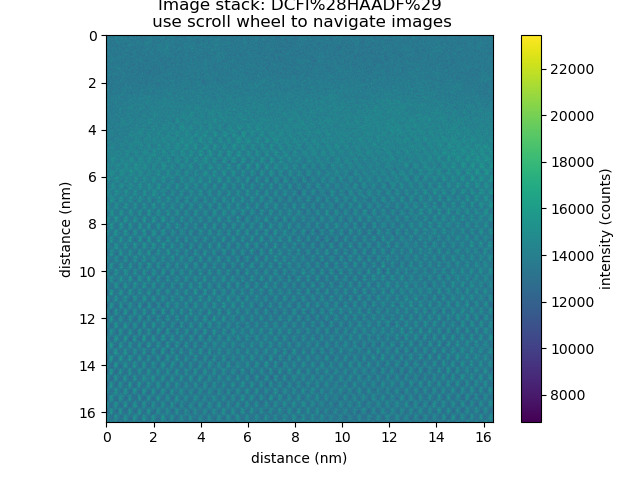

In [22]:
datasets = fileWidget.datasets
dataset = fileWidget.selected_dataset

if dataset.data_type.name != 'IMAGE':
    print('We really would need an image here')

view = dataset.plot()

## Power Spectrum of Image

In [23]:
dataset.original_metadata

{'Core': {'MetadataDefinitionVersion': '7.9',
  'MetadataSchemaVersion': 'v1/2013/07',
  'guid': '00000000000000000000000000000000',
  'UserId': 'ahoust17'},
 'Instrument': {'ControlSoftwareVersion': '3.9.1',
  'Manufacturer': 'FEI Company',
  'InstrumentId': '4018',
  'InstrumentClass': 'Titan',
  'InstrumentModel': 'Spectra',
  'ComputerName': 'TITAN52340180'},
 'Acquisition': {'AcquisitionStartDatetime': {'DateTime': '1699290917'},
  'AcquisitionDatetime': {'DateTime': '0'},
  'BeamType': '',
  'SourceType': 'XFEG'},
 'Optics': {'GunLensSetting': '831.280517578125',
  'ExtractorVoltage': '3600.03662109375',
  'AccelerationVoltage': '200000',
  'SpotIndex': '7',
  'C1LensIntensity': '-0.42847558856010437',
  'C2LensIntensity': '0.42215600609779358',
  'C3LensIntensity': '0.50287246704101563',
  'ObjectiveLensIntensity': '0.8239816427230835',
  'IntermediateLensIntensity': '0.060336265712976456',
  'DiffractionLensIntensity': '0.19139078259468079',
  'Projector1LensIntensity': '0.2809

fft :
	smoothing : 1
	minimum_intensity : 10.122878251923055
	maximum_intensity : 17.86281328568153
source:  p1-3-hr3


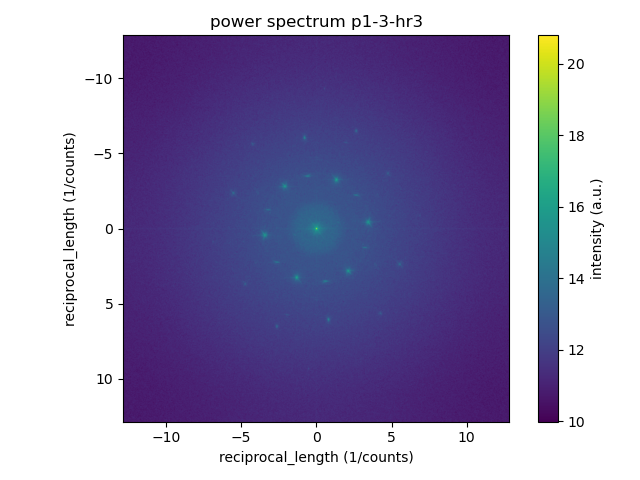

In [6]:
power_spectrum = pyTEMlib.image_tools.power_spectrum(dataset, smoothing=1)

power_spectrum.view_metadata()
print('source: ', power_spectrum.source)
view = power_spectrum.plot()

## Spot Detection in Fourier Transform

Change the spot_threshold value slightly up or down (down is more spots)

Found 30 reflections


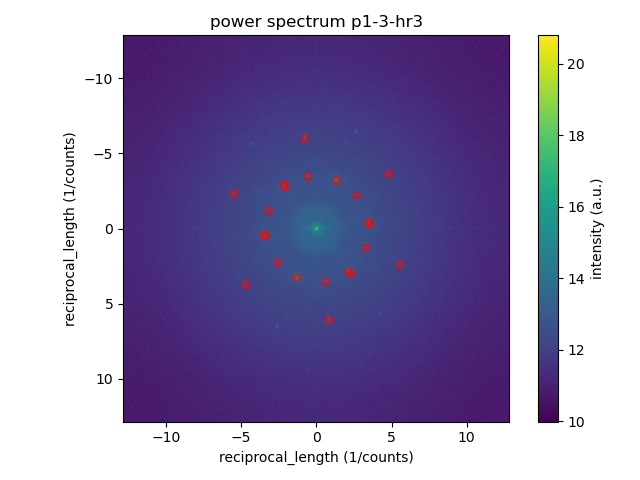

In [7]:
# ------Input----------
spot_threshold=0.05
# ---------------------

spots, _ = pyTEMlib.image_tools.diffractogram_spots(power_spectrum, spot_threshold=spot_threshold)
spots = spots[np.linalg.norm(spots[:,:2],axis=1)<7,:]
spots = spots[np.linalg.norm(spots[:,:2],axis=1)>0.5,:]
power_spectrum.plot()

plt.gca().scatter(spots[:,0],spots[:,1], color='red', alpha=0.4);

## Adaptive Fourier Filter

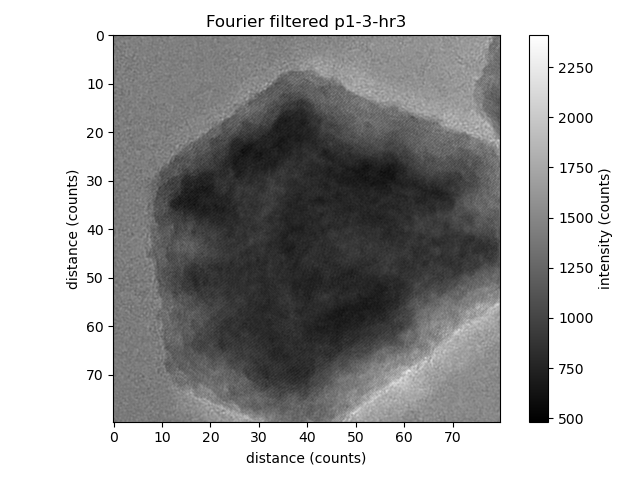

In [8]:
filtered_dataset = pyTEMlib.image_tools.adaptive_fourier_filter(dataset, spots, 
                                                                low_pass=2.0, reflection_radius=.3)
view = filtered_dataset.plot(cmap='gray')

Let's see what we did - In Fourier space, of course.

fft :
	smoothing : 1
	minimum_intensity : 10.122878251923055
	maximum_intensity : 17.86281328568153
source:  p1-3-hr3


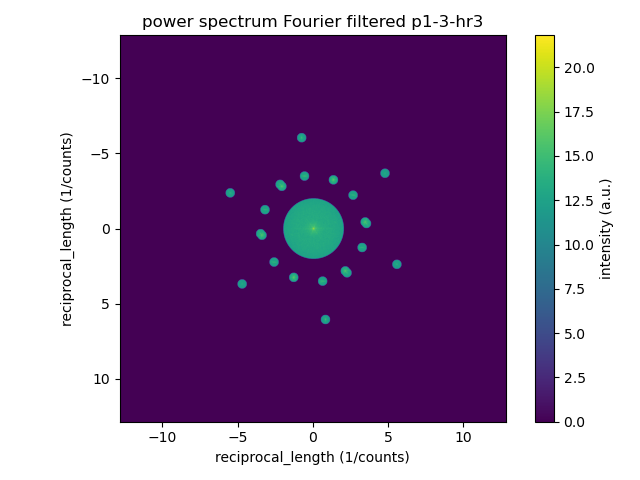

In [9]:
filtered_power_spectrum = pyTEMlib.image_tools.power_spectrum(filtered_dataset, smoothing=0)

power_spectrum.view_metadata()
print('source: ', power_spectrum.source)
view = filtered_power_spectrum.plot()

Please note that the spots are ordered from center to outside.

The third parameter of a spot is its angle.

In [10]:
print(spots[:5])

[[-2.62027028  2.21908057 -0.86811058]
 [ 2.62027028 -2.21908057  2.27348207]
 [-3.4226497   0.43880124 -1.44328677]
 [ 3.4226497  -0.43880124  1.69830589]
 [-3.22205484 -1.25371784 -1.94187537]]


## Log the result

In [11]:
filtered_dataset.title = 'Fourier_Filtered_Image'
datasets.update({'Log_000': filtered_dataset})

### Save Datasets to file

In [12]:
group = pyTEMlib.file_tools.save_dataset(datasets, filename=dataset.metadata['filename'])

Cannot overwrite file. Using:  p1-3-hr3-1.hf5


C:\Users\gduscher\AppData\Local\anaconda3\lib\site-packages\pyNSID\io\hdf_io.py:111: UserWarning: main_data_name should not contain the "-" character. Reformatted name from:p1-3-hr3 to p1_3_hr3
  warn('main_data_name should not contain the "-" character. Reformatted'
C:\Users\gduscher\AppData\Local\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
C:\Users\gduscher\AppData\Local\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',


A convenient function to select a dataset (for further processing, visualization or whatever)

In [13]:
chooser = pyTEMlib.file_tools.ChooseDataset(datasets)

Dropdown(description='select dataset:', options=('Channel_000: p1-3-hr3', 'Log_000: Fourier_Filtered_Image'), …

In [14]:
chooser.dataset.metadata

{'analysis': 'adaptive fourier filtered',
 'spots': array([[-2.62027028,  2.21908057, -0.86811058],
        [ 2.62027028, -2.21908057,  2.27348207],
        [-3.4226497 ,  0.43880124, -1.44328677],
        [ 3.4226497 , -0.43880124,  1.69830589],
        [-3.22205484, -1.25371784, -1.94187537],
        [ 3.22205484,  1.25371784,  1.19971728],
        [ 1.31640373, -3.23459202,  2.75508635],
        [-1.31640373,  3.23459202, -0.38650631],
        [-2.10624597, -2.80832796, -2.49809154],
        [ 2.10624597,  2.80832796,  0.64350111],
        [-3.51040995,  0.33850382, -1.47466498],
        [ 3.51040995, -0.33850382,  1.66692768],
        [-0.60178456, -3.48533559, -2.97061654],
        [ 0.60178456,  3.48533559,  0.17097612],
        [-2.21908057, -2.93369974, -2.49400159],
        [ 2.21908057,  2.93369974,  0.64759107],
        [-4.73905343,  3.67339327, -0.91140362],
        [ 4.73905343, -3.67339327,  2.23018903],
        [-5.52889567, -2.36952671, -1.97568811],
        [ 5.528895

A tree-like plot of the file

In [15]:
print(dataset.h5_dataset.file.filename)
pyTEMlib.file_tools.h5_tree(dataset.h5_dataset.file)

C:\Users\gduscher\Documents\Github\pyTEMlib\example_data\p1-3-hr3-1.hf5
/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ p1_3_hr3
      --------
      ├ metadata
        --------
        ├ experiment
          ----------
      ├ original_metadata
        -----------------
        ├ DM
          --
        ├ DocumentObjectList
          ------------------
          ├ 0
            -
            ├ AnnotationGroupList
              -------------------
              ├ 0
                -
                ├ Font
                  ----
                ├ ObjectTags
                  ----------
            ├ ImageDisplayInfo
              ----------------
              ├ DimensionLabels
                ---------------
              ├ MainSliceId
                -----------
            ├ ObjectTags
              ----------
        ├ DocumentTags
          ------------
        ├ Image Behavior
          --------------
          ├ UnscaledTransform
            ----------

## Close File
let's close the file but keep the filename

In [16]:
filename = dataset.h5_dataset.file.filename
dataset.h5_dataset.file.close()

## Simulate new notebook
We can now simulate a new notebook and open the file again.



In [17]:
new_dataset= pyTEMlib.file_tools.open_file(filename)
choose_image = pyTEMlib.file_tools.ChooseDataset(new_dataset)

Dropdown(description='select dataset:', options=('Channel_000: p1_3_hr3', 'Log_000: Fourier_Filtered_Image'), …

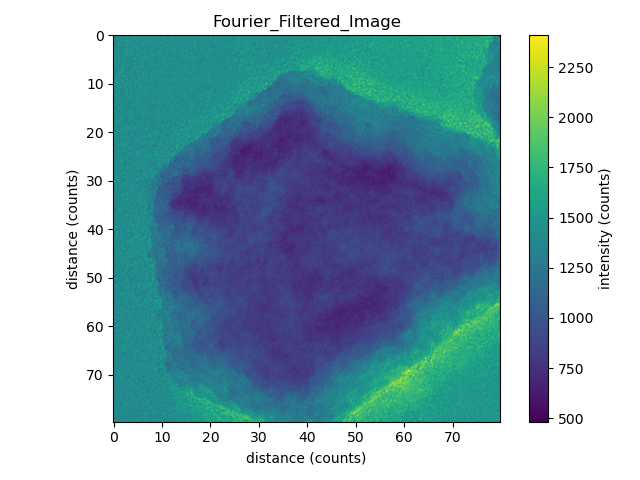

In [18]:
view = choose_image.dataset.plot()

We want to make an image operation of the images in the file.

In [19]:
choose_image = pyTEMlib.file_tools.ChooseDataset(new_dataset)
print('       subtract')
choose_image2 = pyTEMlib.file_tools.ChooseDataset(new_dataset)

Dropdown(description='select dataset:', options=('Channel_000: p1_3_hr3', 'Log_000: Fourier_Filtered_Image'), …

       subtract


Dropdown(description='select dataset:', options=('Channel_000: p1_3_hr3', 'Log_000: Fourier_Filtered_Image'), …

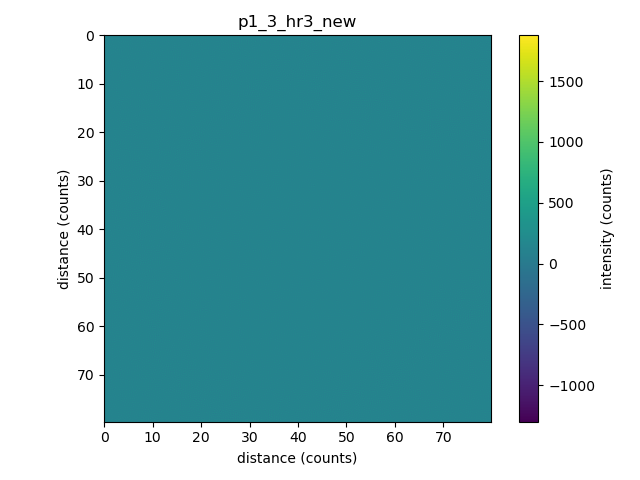

In [20]:
new_image = np.array(choose_image.dataset) - np.array(choose_image2.dataset)
new_image = choose_image.dataset.like_data(new_image)
vew = new_image.plot()

In [21]:
choose_image.dataset.metadata

{'filename': 'C:\\Users\\gduscher\\Documents\\Github\\pyTEMlib\\example_data\\p1-3-hr3.dm3',
 'experiment': {'acceleration_voltage': 199990.28125,
  'exposure_time': 1.0,
  'microscope': 'Libra 200 MC'}}